In [1]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)

import cmasher as cmr

In [2]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [3]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [4]:
def plot_scatter_data(data_df, x_col="x", y_col="y",x_name=None,y_name=None, series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, color_marker_map=None, num_colors=None, num_markers=None, num_cols=None, filter_list=None, legend_sort_indices=None, shorten_legend_indices=None, legend_unique_indices=None, title="Figure Title", marker_size=None,figure_size=None,legend_loc=None, bbox_to_anchor=None, grid=True, save_path=None, show=True):
    
    # give each point a unique marker and color
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    # markers = ["*", "s", "^", "p", "v", "<", "P", ">", "h", "H", "+",  "X", "D",  "|", "d", "x", "_", "o"]
    markers = ["o", "X", "v","^", "s", "p", "<", "P", ">", "h", "H", "+" , "D", "d", "x", "p"]

    if num_markers is not None:
        markers = markers[:num_markers]
    
    all_possible_color_and_marker_combos = [(color, marker) for color in cmap for marker in markers]
    
    #plot using plt.scatter
    # make figsize larger if num_cols is not None adn num_cols > 1
    #  and scale marker size

    fig, ax = plt.subplots(figsize=figure_size)
    marker_size = marker_size
    
    # sort data_df by series_readable_id_col
    # data_df = data_df.sort_values(by=[series_readable_id_col])

    if filter_list is not None:
        # remove data where series_readable_id_map[row[series_readable_id_col]] is in filter_list
        # print(f"Col for filtering:{data_df[series_readable_id_col].apply(series_readable_id_map)[0]}")
        data_df = data_df[~data_df[series_readable_id_col].apply(series_readable_id_map).isin(filter_list)]

    for i, row in data_df.iterrows():

        if isinstance(series_readable_id_map, dict):
            label = series_readable_id_map[row[series_readable_id_col]]
        elif isinstance(series_readable_id_map, Callable):
            # print(row[series_readable_id_col])
            label = series_readable_id_map(row[series_readable_id_col])
            # print(label)
        else:
            label = row[series_readable_id_col]
        
        if color_marker_map is not None and isinstance(color_marker_map, Callable):
            # print(f"Using color marker callable")
            color_idx, marker_idx = color_marker_map(series_readable_id_map(row[series_readable_id_col]))
            if isinstance(color_idx,int):
                color = cmap[color_idx]
            else:
                color = color_idx
            if isinstance(marker_idx,int):
                marker = markers[marker_idx]
            else:
                marker = marker_idx
            # print(f"color: {color}, marker: {marker}")
        else:
            if special_color_map and row[series_readable_id_col] in special_color_map.keys():
                if isinstance(special_color_map[row[series_readable_id_col]], int):
                    color = cmap[special_color_map[row[series_readable_id_col]]]
                else:
                    color = special_color_map[row[series_readable_id_col]]
            else:
                # color = cmap[i]
                color = all_possible_color_and_marker_combos[i][0]
            # marker = markers[i]
            marker = all_possible_color_and_marker_combos[i][1]

        ax.scatter(row[x_col], row[y_col], label=label, color=color, marker=marker, alpha=0.8, sizes=[marker_size])
    
    # sort legend the value of y_col and then x_col
    handles, labels = ax.get_legend_handles_labels()
    x_vals = data_df[x_col]
    y_vals = data_df[y_col]

    if legend_sort_indices is not None:
        label_tups = [lab.split(",") for lab in labels]
        # label_tups = [tuple([lab[i] for i in legend_name_indices]) for lab in label_tups]
        # sort by label_tups in their order
        # handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: [[t[1][i] for i in legend_sort_indices],t[2]], reverse=False))
        handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: ([[t[1][i] for i in legend_sort_indices],t[2]] if t[1][0] != "Wiki" else [["C4-z",-1],-1]), reverse=False))
        if legend_unique_indices:
            legend_dict = {tuple([label_tup[i] for i in legend_unique_indices]): [handle,label_tup] for handle,label_tup in zip(handles,label_tups)}
            handles, label_tups = zip(*legend_dict.values())
        if shorten_legend_indices:
            label_tups = [[lab[i] for i in shorten_legend_indices] for lab in label_tups]
        labels = [",".join(lab) for lab in label_tups]
        legend_title = f""
    else:
        # sort by x/y_vals
        handles, labels, _, _ = zip(*sorted(zip(handles, labels, x_vals, y_vals), key=lambda t: (t[3],t[2]), reverse=True))
        legend_title = f"(Sorted desc. by {y_name if y_name else y_col})"


    # sort by labels if num_cols more than 1, make the legend outside the plot to the RHS
    # and increase marker size
    # if num_cols > 1:
    #     # ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols)
    #     # make legend taller
    #     ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols, handletextpad=0.1, columnspacing=0.2, title=legend_title, fontsize=12)
    # else:
    #     ax.legend(handles, labels,loc=legend_loc, ncol=(num_cols if num_cols is not None else 1), title=legend_title, fontsize=12)
    if bbox_to_anchor is not None:
        ax.legend(handles, labels, bbox_to_anchor=bbox_to_anchor, loc="center left", ncol=(num_cols if num_cols is not None else 1), handletextpad=0.1, columnspacing=0.2, title=legend_title, fontsize=12)
    else:
        ax.legend(handles, labels, loc=legend_loc, ncol=(num_cols if num_cols is not None else 1), handletextpad=0.1, columnspacing=0.2, title=legend_title, fontsize=12)
    
    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_name if x_name else x_col)
    plt.ylabel(y_name if y_name else y_col)

    # turn on grid
    ax.grid(grid)

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [5]:
def name_extractor(x):
    
    x = x.replace("50_200_", "")
    x = x.replace("core_", "")
    x = x.replace("gen_attacked_", "")
    x = x.replace("pile_", "")
    x = x.replace("c4_", "C4-en_")
    x = x.replace("free_law", "Law")
    x = x.replace("pubmed", "Med")
    x = x.replace("github", "Github")
    x = x.replace("wikitext", "Wiki")
    x = x.replace("uspto", "Patents")
    x = x.replace("gpt_eval", "GPT")
    x = x.replace("gpt_p4_eval", "GPT")
    x = x.replace("dipper_eval", "Dipper")
    x = x.replace("dipper_high_eval", "Dipper")
    x = x.replace("simple_1_", "C4-News_llama-7b-base_")

    x = x.replace("llama-7b-base", "Llama-7B")
    x = x.replace("opt-6-7b", "OPT-6.7B")
    x = x.replace("llama-7b-vicuna-v1-1", "Vicuna-7B")


    tup_x = x.split("_")
    
    # return x_dict
    return ",".join([str(elm) for elm in tup_x])


In [6]:
fig_name = "data_model_ablation_z_psp_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

In [7]:
# name_col = df["Name"]
name_col = df["Name"].apply(name_extractor)
# name_col

In [8]:
# (dataset,model,attack)

In [9]:
color_order = [
    "Github",
    "Law",
    "Patents",
    "Med",
    # "C4-News",
    # "C4-en",
    # "Wiki",
]

marker_order = [
    "Llama-7B",
    "Vicuna-7B",
    "OPT-6.7B",
]


def color_marker_map(x):

    x_tup = x.split(",")
    assert len(x_tup) == 3

    dataset = x_tup[0]
    model = x_tup[1]


    if dataset == "C4-News":
        color = "black"
        marker = marker_order.index(model)
    elif dataset == "C4-en":
        color = "gray"
        marker = marker_order.index(model)
    elif dataset == "Wiki":
        color = "saddlebrown"
        marker = marker_order.index(model)
    else:
        color = color_order.index(dataset)
        marker = marker_order.index(model)

    return color, marker

filter_list = [
    "algorithm-3,Dipper",
    "algorithm-3,GPT",
]
    

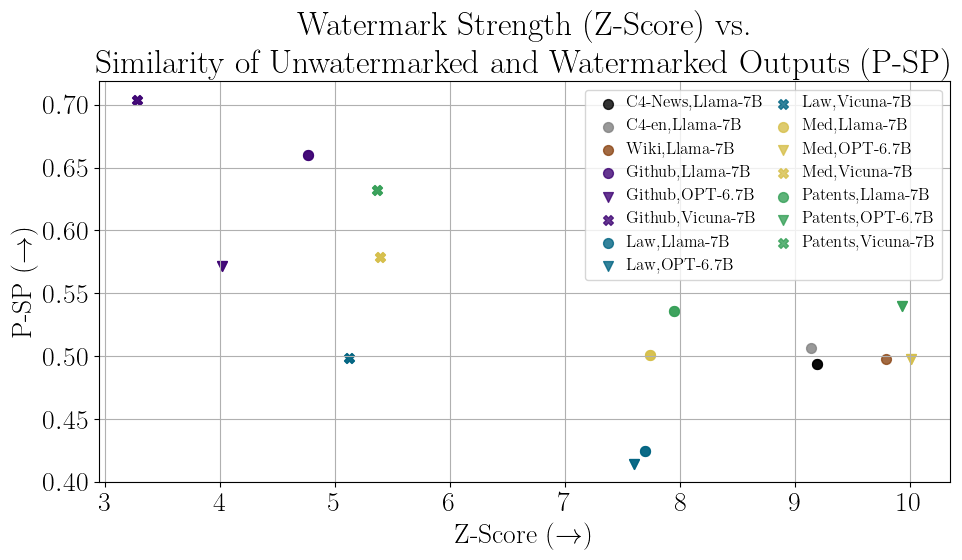

In [10]:
plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_no_wm_output_vs_w_wm_output_p_sp_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"P-SP $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=4,
    num_markers=3,
    num_cols=2,
    marker_size=50,
    figure_size=(10,6),
    legend_loc="upper right",
    title="Watermark Strength (Z-Score) vs.\nSimilarity of Unwatermarked and Watermarked Outputs (P-SP)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [11]:
fig_name = "data_model_ablation_z_logdiv_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

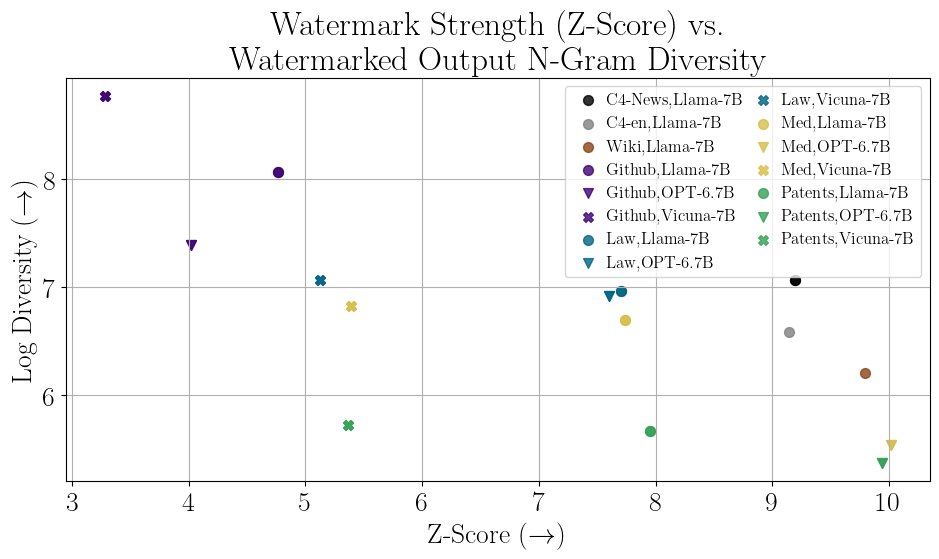

In [12]:
plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_w_wm_output_log_diversity_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"Log Diversity $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=4,
    num_markers=3,
    num_cols=2,
    marker_size=50,
    figure_size=(10,6),
    legend_loc="upper right",
    title="Watermark Strength (Z-Score) vs.\nWatermarked Output N-Gram Diversity",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [13]:
fig_name = "data_model_ablation_z_repetition2_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,Name,f_200p25m25_w_wm_output_z_score_mean,f_200p25m25_w_wm_output_repetition_2_mean,_wandb
0,pile_uspto_opt-6-7b_gen_attacked_dipper_eval,9.935677,0.290999,NaN
1,core_algorithm-3_50_200_dipper_high_eval,10.057236,0.112082,NaN
2,pile_pubmed_opt-6-7b_gen_attacked_dipper_eval,10.012369,0.265712,NaN
3,pile_pubmed_opt-6-7b_gen_attacked_gpt_eval,10.012369,0.265712,NaN
4,pile_free_law_opt-6-7b_gen_attacked_dipper_eval,7.600258,0.198272,NaN
5,pile_uspto_llama-7b-base_gen_attacked_dipper_eval,7.951518,0.235688,NaN
6,core_simple_1_50_200_dipper_high_eval,9.193640,0.108495,NaN
7,pile_uspto_opt-6-7b_gen_attacked_gpt_eval,9.935677,0.290999,NaN
8,pile_pubmed_llama-7b-base_gen_attacked_gpt_eval,7.739721,0.149759,NaN
9,core_algorithm-3_50_200_gpt_p4_eval,10.057236,0.112082,NaN


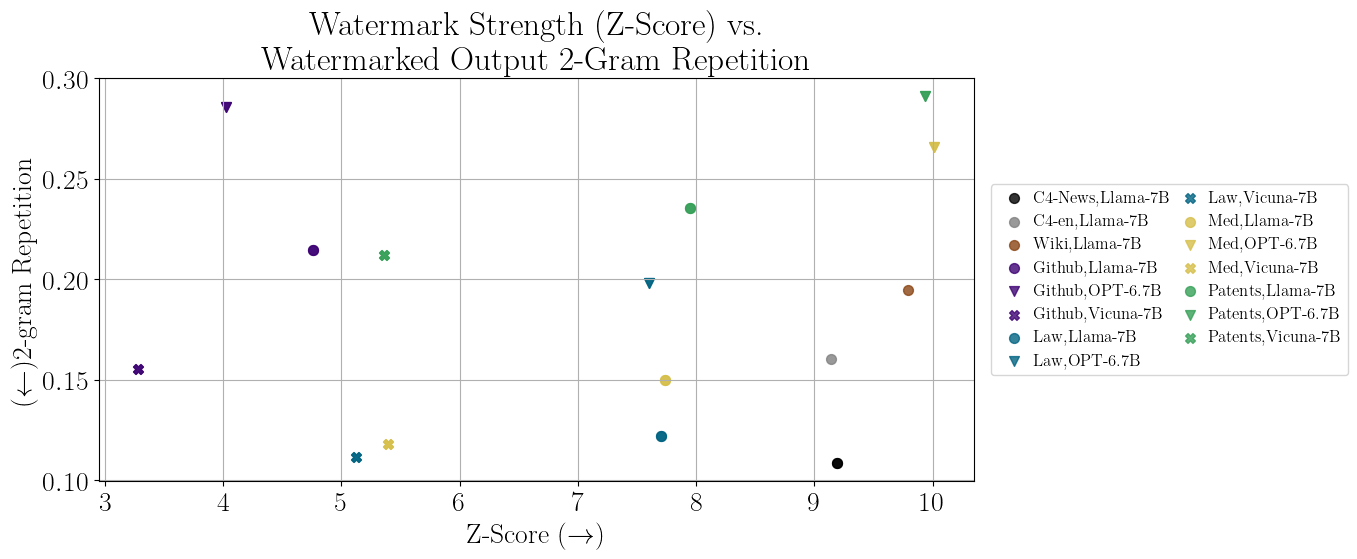

In [14]:
plot_scatter_data(
    data_df=df,
    x_col="f_200p25m25_w_wm_output_z_score_mean",
    y_col="f_200p25m25_w_wm_output_repetition_2_mean",
    x_name=r"Z-Score $(\rightarrow)$",
    y_name=r"$(\leftarrow) $2-gram Repetition",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[0,1],
    legend_unique_indices = [0,1],
    shorten_legend_indices = [0,1],
    filter_list=filter_list,
    num_colors=4,
    num_markers=3,
    num_cols=2,
    marker_size=50,
    figure_size=(14,6),
    # legend_loc="upper right",
    bbox_to_anchor=(1.01,0.5),
    title="Watermark Strength (Z-Score) vs.\nWatermarked Output 2-Gram Repetition",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [15]:
def plot_bar_data(data_df,x_col="x",series_readable_id_col="name", fig_size=(8, 5), series_readable_id_map=None, x_label=None, y_label=None, y_lim=None, y_tick_spec=None, y_err_df = None, all_groups = None, overall_position_list=None, special_color_map=None, num_colors=None, title="Figure Title", grid=True, save_path=None, show=True):

    # make a simple bar chart of the data labellinig each by it's series_readable_id_col
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    
    #plot using plt.bar
    # but lets make subplots for heirarchical groups
    # first level, on left we want bars where name contains 50_200 and right is where name has 100_600
    # in each of those groups, we want to split into set where contains cp_attack and where doesn't
    # them finally we sort each final group by x_col
    # mak sure we position them separately on the x axis with some space between them

    fig, ax = plt.subplots(figsize=fig_size)

    global_idx = 0
    all_labels = []
    for i, grp in enumerate(all_groups):
        if isinstance(series_readable_id_map, dict):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(series_readable_id_map)
        elif isinstance(series_readable_id_map, Callable):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(lambda x: series_readable_id_map(x))

        for j, x_val in enumerate(grp[x_col]):
            label = grp[series_readable_id_col].iloc[j]
            all_labels.append(label)

            if special_color_map is not None:
                color = special_color_map(label)
                if isinstance(color, int):
                    color = cmap[color]
            else:
                color = cmap[j]
            ax.bar(overall_position_list[global_idx], x_val, color=color, alpha=0.8)
            # if y_err_df is not None:
            if y_err_df is not None and label in y_err_df[series_readable_id_col].values:
                print(label)
                print(y_err_df[series_readable_id_col].values)
                y_err = y_err_df[y_err_df[series_readable_id_col] == label][x_col]
                print(y_err)
                ax.errorbar(overall_position_list[global_idx], x_val, yerr=y_err, fmt="none", ecolor="black", capsize=5, capthick=2, zorder=10)


            global_idx += 1

    # Set the x ticks to be the names located at the center of the correct bar
    ax.set_xticks(overall_position_list, all_labels)


    # turn on grid  
    ax.set_axisbelow(True)
    ax.grid(grid,zorder=0,axis="y")
    # increase horiz grid density 
    ax.xaxis.grid(which="minor", linestyle="-", linewidth=0.5, color="black", zorder=0)
    if y_tick_spec is not None:
        ax.set_yticks(y_tick_spec)

    

    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_label)
    plt.ylabel(y_label if y_label else x_col)

    # set y lim to be 0 to 1
    ax.set_ylim(y_lim)

    # angle labels
    plt.xticks(rotation=45, ha="right")

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [16]:
def color_map(x):

    x_tup = x.split(",")

    dataset = x_tup[0]

    if dataset == "C4-News":
        color = "black"
    elif dataset == "C4-en":
        color = "gray"
    elif dataset == "Wiki":
        color = "saddlebrown"
    else:
        color = color_order.index(dataset)

    return color

In [17]:
fig_name = "data_model_ablation_clean_AUC"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

df["Name"] = df["Name"].apply(name_extractor)

# sort, but make "Wiki" first
df["Name_for_sort"] = df["Name"].apply(lambda x: "C4-z" + x if x.startswith("Wiki") else x)
df = df.sort_values(by=["Name_for_sort"])
df = df.drop(columns=["Name_for_sort"])

df = df[~df["Name"].isin(filter_list)]
# df

In [18]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

# the Name is a tuple with dataset, model, attack
# we want to group by dataset, then model, then attack
# and drop the second attack group 'Dipper' since were plotting clean AUC here
all_groups = []
for dataset in df["Name"].apply(lambda x: x.split(",")[0]).unique():
    dataset_df = df[df["Name"].apply(lambda x: x.split(",")[0]) == dataset]
    # all_groups.append(dataset_df)
    # for model in dataset_df["Name"].apply(lambda x: x.split(",")[1]).unique():
    #     model_df = dataset_df[dataset_df["Name"].apply(lambda x: x.split(",")[1]) == model]
    #     # all_groups.append(model_df)
    for attack in dataset_df["Name"].apply(lambda x: x.split(",")[2]).unique()[:1]: # just take the first attack
        attack_df = dataset_df[dataset_df["Name"].apply(lambda x: x.split(",")[2]) == attack]
        all_groups.append(attack_df)

# for all grps trim the attack from the name tup
for i, grp in enumerate(all_groups):
    all_groups[i]["Name"] = all_groups[i]["Name"].apply(lambda x: ",".join(x.split(",")[:2]))

all_groups



/tmp/ipykernel_3305098/319256877.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_groups[i]["Name"] = all_groups[i]["Name"].apply(lambda x: ",".join(x.split(",")[:2]))


[               Name  _wandb  z_score_roc_auc
 6  C4-News,Llama-7B     NaN         0.999471,
               Name  _wandb  z_score_roc_auc
 22  C4-en,Llama-7B     NaN         0.981624,
              Name  _wandb  z_score_roc_auc
 12  Wiki,Llama-7B     NaN         0.999125,
                 Name  _wandb  z_score_roc_auc
 26   Github,Llama-7B     NaN         0.891280
 25   Github,OPT-6.7B     NaN         0.818759
 27  Github,Vicuna-7B     NaN         0.847493,
              Name  _wandb  z_score_roc_auc
 13   Law,Llama-7B     NaN         0.992832
 4    Law,OPT-6.7B     NaN         0.865817
 21  Law,Vicuna-7B     NaN         0.979616,
              Name  _wandb  z_score_roc_auc
 10   Med,Llama-7B     NaN         0.998791
 2    Med,OPT-6.7B     NaN         0.997903
 17  Med,Vicuna-7B     NaN         0.991420,
                  Name  _wandb  z_score_roc_auc
 5    Patents,Llama-7B     NaN         0.999444
 0    Patents,OPT-6.7B     NaN         0.998106
 20  Patents,Vicuna-7B     NaN         0

/tmp/ipykernel_3305098/240164332.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp[series_readable_id_col] = grp[series_readable_id_col].map(lambda x: series_readable_id_map(x))


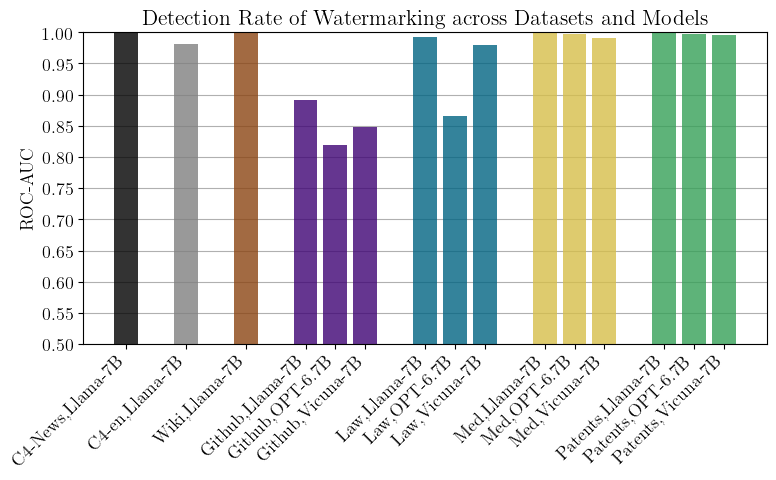

In [19]:
# hardcode 27 bar positions leaving out the 3 required for the gaps
# 6 bars per group, 4 groups, 3 gaps
# width is 7 bars - the 1 gap bar
# width = 2 

widths = [1,1,1,3,3,3,3]

offset = 0

overall_position_list = []
for width in widths:
    overall_position_list += list(range(offset, offset+width))
    offset += width + 1

plot_bar_data(
    df,
    x_col="z_score_roc_auc",
    # x_label="Watermarking Settings",
    y_label="ROC-AUC",
    fig_size=(8,5),
    y_lim=(0.5,1.0),
    y_tick_spec=np.arange(0, 1.1, 0.05),
    series_readable_id_col="Name",
    all_groups=all_groups,
    overall_position_list=overall_position_list,
    num_colors = 4,
    special_color_map=color_map,
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking across Datasets and Models",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
    show=True
)
    

In [20]:
fig_name = "data_model_ablation_attacked_AUC"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

df["Name"] = df["Name"].apply(name_extractor)

# sort, but make "Wiki" first
df["Name_for_sort"] = df["Name"].apply(lambda x: "C4-z" + x if x.startswith("Wiki") else x)
df = df.sort_values(by=["Name_for_sort"])
df = df.drop(columns=["Name_for_sort"])

df = df[~df["Name"].isin(filter_list)]
# df

In [21]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})


# the Name is a tuple with dataset, model, attack
# we want to group by dataset, then model, then attack
# and drop the second attack group 'Dipper' since were plotting clean AUC here
all_groups = []
for dataset in df["Name"].apply(lambda x: x.split(",")[0]).unique():
    dataset_df = df[df["Name"].apply(lambda x: x.split(",")[0]) == dataset]
    # all_groups.append(dataset_df)
    # for model in dataset_df["Name"].apply(lambda x: x.split(",")[1]).unique():
    #     model_df = dataset_df[dataset_df["Name"].apply(lambda x: x.split(",")[1]) == model]
    #     # all_groups.append(model_df)
    # for attack in dataset_df["Name"].apply(lambda x: x.split(",")[2]).unique()[:1]: # just take the first attack
    #     attack_df = dataset_df[dataset_df["Name"].apply(lambda x: x.split(",")[2]) == attack]
    all_groups.append(dataset_df)

# all_groups


/tmp/ipykernel_3305098/240164332.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp[series_readable_id_col] = grp[series_readable_id_col].map(lambda x: series_readable_id_map(x))


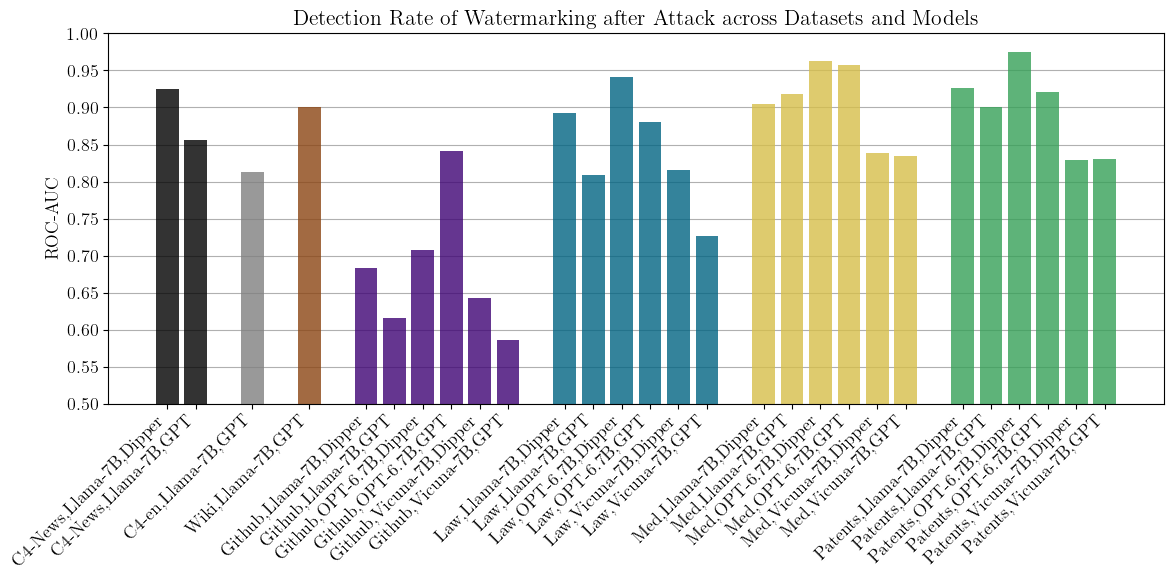

In [22]:

widths = [2,1,1,6,6,6,6]

offset = 0

overall_position_list = []
for width in widths:
    overall_position_list += list(range(offset, offset+width))
    offset += width + 1

plot_bar_data(
    df,
    x_col="attacked_z_score_roc_auc",
    # x_label="Watermarking Settings",
    y_label="ROC-AUC",
    fig_size=(12,6),
    y_lim=(0.5,1.0),
    y_tick_spec=np.arange(0, 1.1, 0.05),
    series_readable_id_col="Name",
    all_groups=all_groups,
    overall_position_list=overall_position_list,
    num_colors = 4,
    special_color_map=color_map,
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking after Attack across Datasets and Models",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
    show=True
)
    